Overview:

Step 1: Import required libraries

Step 2: Image loading and Imange Normalisation [size: (224,224,3)]

Step 3: Image denoising using autoencoder

Step 4: Resized Imaage bounding box (bbox) calculation

Step 5: Image augmentation and bounding box (bbox) calculation

Step 6: Update annotation file with updated bounding box (bbox) calculation for denoised images and information of augmented images

Step 1: Import required libraries

In [ ]:
import tensorflow as tf
import os
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import numpy as np
import cv2

Step 2: Image Loading and Normalisation

In [ ]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224)) #Input shape will change once images are processed
    img_array = np.array(img)
    return img_array

In [ ]:
train_file = '/content/drive/My Drive/COMP9517/train_annotations'
valid_file = '/content/drive/My Drive/COMP9517/valid_annotations'
train_labels = []
train_images = []
val_labels = []
val_images = []

with open(train_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        train_labels.append(int(id[-1]) - 1)

for file in sorted(os.listdir('/content/drive/My Drive/COMP9517/train/')):
    img_path = os.path.join('/content/drive/My Drive/COMP9517/train/', file)
    img = load_image(img_path)
    train_images.append(img)

with open(valid_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        val_labels.append(int(id[-1]) - 1)

for file in sorted(os.listdir('/content/drive/My Drive/COMP9517/valid/')):
    img_path = os.path.join('/content/drive/My Drive/COMP9517/valid/', file)
    img = load_image(img_path)
    val_images.append(img)

#numpy arrays of images and labels for both sets
train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

#Normalize
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

Step 3: Denoising (Source: https://github.com/therealcyberlord/tensorflow_keras_color_images_denoiser/blob/master/better_denoiser.ipynb)

In [ ]:
def create_denoising_autoencoder(input_shape):
    # Encoder
    inputs = layers.Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(inputs, outputs)
    return autoencoder

Epoch 1/10
16/16 [==============================] - 41s 931ms/step - loss: 0.0579 - val_loss: 0.0426
Epoch 2/10
16/16 [==============================] - 7s 428ms/step - loss: 0.0280 - val_loss: 0.0185
Epoch 3/10
16/16 [==============================] - 7s 425ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 4/10
16/16 [==============================] - 7s 431ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/10
16/16 [==============================] - 7s 433ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/10
16/16 [==============================] - 7s 460ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/10
16/16 [==============================] - 7s 441ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/10
16/16 [==============================] - 7s 448ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/10
16/16 [==============================] - 8s 473ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/10
16/16 [==============================] - 2s 136ms/step


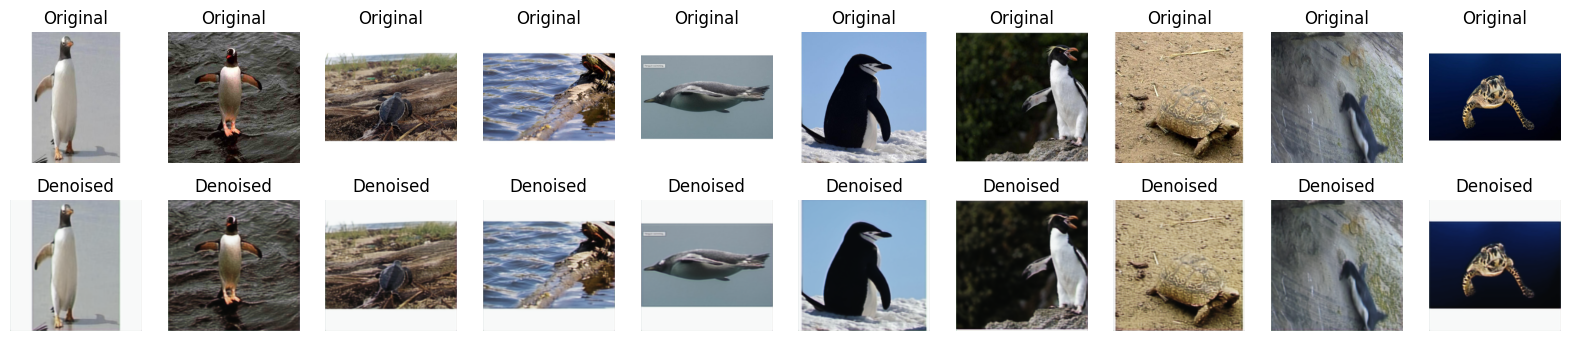

In [ ]:
# Denoising autoencoder
input_shape = (224, 224, 3) # Modify this based on your image dimensions
denoising_autoencoder = create_denoising_autoencoder(input_shape)
denoising_autoencoder.compile(optimizer='adam', loss='mse')

denoising_autoencoder.fit(train_images, train_images,
                          epochs=10,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(val_images, val_images))

denoised_train_images = denoising_autoencoder.predict(train_images)

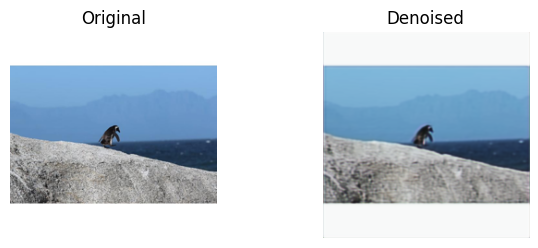

In [ ]:
# Enlarged result
i = 390
# Original image
plt.subplot(2, 2, 1)
plt.imshow(train_images[i])
plt.title("Original")
plt.axis("off")

# Denoised image
plt.subplot(2, 2, 2)
plt.imshow(denoised_train_images[i])
plt.title("Denoised")
plt.axis("off")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

Save denoised image for further training use

In [ ]:
train_image_directory = '/content/drive/My Drive/COMP9517/train/'
output_directory = '/content/drive/MyDrive/COMP9517/denoised'
os.makedirs(output_directory, exist_ok=True)

for i, denoised_image in enumerate(denoised_train_images):
    file_index = str(i).zfill(3)
    denoised_filename = f"image_id_{file_index}.jpg"

    denoised_file_path = os.path.join(output_directory, denoised_filename)
    plt.imsave(denoised_file_path, denoised_image)

In [ ]:
train_file = '/content/drive/My Drive/COMP9517/train_annotations'
with open(train_file, 'r') as f:
    data = f.read()
annotation = pd.DataFrame(eval(data))
column_order = ["id", "image_id", "category_id", "bbox", "area", "segmentation", "iscrowd"]
annotation = annotation[column_order]

Step 4: Resized Imaage bounding box (bbox) calculation

In [ ]:
# Scale bbox due to image resizing
original = annotation['bbox'].tolist()
scaling_factor = 0.35
original_bbox = []
for bbox in original:
    scaled_bbox = [int(coord * scaling_factor) for coord in bbox]
    original_bbox.append(scaled_bbox)

print(original_bbox)

[[41, 8, 71, 212], [45, 28, 114, 154], [78, 104, 69, 64], [163, 38, 60, 67], [4, 84, 213, 53], [6, 38, 153, 161], [111, 21, 112, 175], [53, 89, 161, 128], [114, 103, 86, 120], [57, 75, 120, 92], [70, 86, 44, 46], [25, 82, 183, 71], [125, 73, 53, 47], [67, 66, 97, 157], [106, 106, 11, 33], [7, 25, 103, 170], [117, 143, 27, 21], [49, 65, 118, 77], [121, 136, 25, 29], [31, 94, 170, 72], [40, 60, 78, 79], [120, 10, 67, 212], [110, 103, 11, 31], [51, 45, 87, 88], [43, 39, 153, 165], [0, 64, 219, 107], [86, 99, 120, 71], [25, 72, 180, 78], [87, 57, 78, 123], [84, 70, 102, 86], [31, 70, 127, 102], [74, 93, 75, 77], [41, 29, 134, 163], [87, 143, 82, 55], [85, 36, 68, 82], [154, 20, 47, 196], [115, 70, 46, 81], [52, 34, 60, 122], [128, 56, 95, 37], [23, 109, 119, 27], [11, 1, 129, 172], [80, 82, 65, 59], [59, 95, 104, 76], [81, 94, 111, 72], [70, 99, 72, 54], [38, 79, 129, 50], [116, 91, 33, 45], [51, 51, 134, 142], [104, 54, 40, 123], [50, 104, 128, 119], [11, 46, 177, 133], [52, 65, 97, 126],

Check scaled Bbox on denoised image

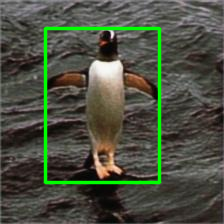

In [ ]:
image_path = os.path.join('/content/drive/MyDrive/COMP9517/denoised/image_id_001.jpg')

image = cv2.imread(image_path)

left, top, width, height = original_bbox[1]
# left *= 0.35
# top *= 0.35
# width *= 0.35
# height *= 0.35
start_point = (int(left), int(top))
end_point = (int(left)+int(width), int(top)+int(height))
color = (0, 255, 0)
thickness = 2
lineType = cv2.LINE_AA
cv2.rectangle(image, start_point, end_point, color, thickness, lineType)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Step 5: Image augmentation and bounding box (bbox) calculation

Image Augmentation function

In [ ]:
def apply_affine_transform(image, bbox):
    # Convert the bounding box to imgaug BoundingBoxesOnImage format
    # given bbox format: [xmin, ymin, bwidth, bheight]
    # imgaug bbox format: [xmin, ymin, xmax, ymax]
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[0]) + int(bbox[2])
    y2 = int(bbox[1]) + int(bbox[3])
    bounding_boxes = [BoundingBox(x1, y1, x2, y2)]

    # Create an Augmenter object with desired augmentation techniques
    augmenter = iaa.Sequential([
        iaa.Affine(
            rotate=(-5, 5),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale=(0.9, 1.1)
        ),
        iaa.Fliplr(0.5),
        iaa.ChangeColorTemperature((4000, 10000)),
        iaa.MultiplyHue((0.5, 1.5))
    ])

    # Convert image to imgaug format
    image_aug_uint8 = (image * 255).astype(np.uint8)
    image_aug = ia.imresize_single_image(image_aug_uint8, (image.shape[1], image.shape[0]))

    # Convert bounding boxes to imgaug format
    bbs_aug = BoundingBoxesOnImage(bounding_boxes, shape=image.shape)

    # Apply augmentation
    image_aug_uint8, bbs_aug = augmenter(image=image_aug, bounding_boxes=bbs_aug)

    # Convert augmented image back to float32 for further processing (if needed)
    image_aug = image_aug_uint8.astype(np.float32) / 255.0

    # Convert bounding boxes back to [xmin, ymin, xmax, ymax] format
    augmented_bbox = bbs_aug.to_xyxy_array()[0]

    # Convert bbox array to list
    augmented_bbox = list(augmented_bbox)

    # Convert bbox back to the given format [xmin, ymin, bwidth, bheight]
    xmin, ymin, xmax, ymax = augmented_bbox
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    bwidth = xmax - xmin
    bheight = ymax - ymin

    bbox_aug = [xmin, ymin, bwidth, bheight]

    return image_aug, bbox_aug

In [ ]:
# Data augmentation to the denoised images
augmented_images = []
augmented_bboxes = []
num_augmentations = 10
count = 500
im = 0
number = 0
id = []
image_id = []

for image in denoised_train_images:
    for j in range(num_augmentations):
        image_aug, bbox_aug = apply_affine_transform(image, original_bbox[im])
        augmented_bboxes.append(bbox_aug)
        augmented_images.append(image_aug)
        id.append(count)
        image_id.append(im)
        count += 1
    im += 1

# Convert the augmented images to a numpy array
augmented_images = np.array(augmented_images)

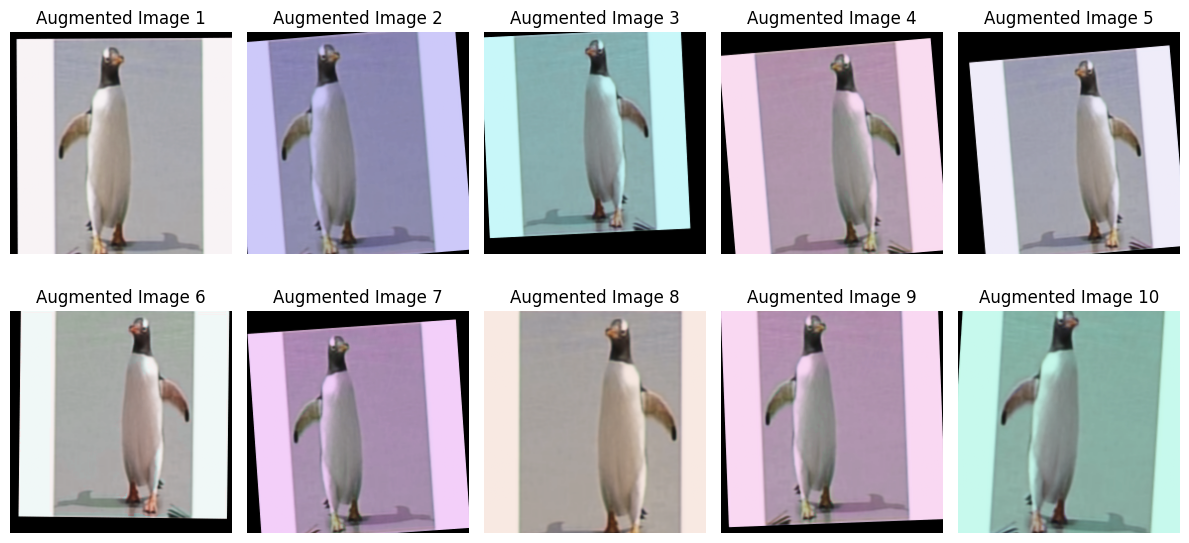

In [ ]:
# Visualise augmentation
n = 10  # Number of augmented images to display
rows = 2
cols = n // rows

plt.figure(figsize=(12, 6))

# Loop over the augmented images
for i in range(n):
    # Select a random augmented image
    augmented_image = augmented_images[i]

    # Display the augmented image in the appropriate row and column
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(augmented_image)
    plt.title(f"Augmented Image {i+1}")
    plt.axis("off")

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

Verifying the bbox calculation with augmented images

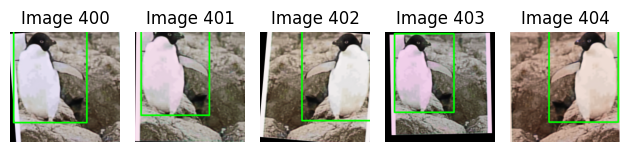

In [ ]:
j = 400
# Loop over 5 images starting from index 177
for i in range(j, j + 5):
    augmented_image = augmented_images[i]
    # Convert the augmented image to uint8 format (assuming the pixel values are between 0 and 1)
    augmented_image_uint8 = (augmented_image * 255).astype(np.uint8)

    left, top, width, height = augmented_bboxes[i]
    # left *= 0.35
    # top *= 0.35
    # width *= 0.35
    # height *= 0.35
    start_point = (int(left), int(top))
    end_point = (int(left) + int(width), int(top) + int(height))

    color = (0, 255, 0)
    thickness = 2
    lineType = cv2.LINE_AA
    cv2.rectangle(augmented_image_uint8, start_point, end_point, color, thickness, lineType)

    # Display the augmented image with the bounding box
    plt.subplot(1, 5, i - j + 1)
    plt.imshow(augmented_image_uint8)
    plt.title(f"Image {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Save augmented images for training

In [ ]:
output_dir = '/content/drive/My Drive/COMP9517/5k_train/'
os.makedirs(output_dir, exist_ok=True)
aug_id = []
name = []
i = 0

for i, augmented_image in enumerate(augmented_images):
    aug_id.append(500 + i)
    filename = f"augmented_{i}.jpg"
    name.append(filename)

    augmented_file_path = os.path.join(output_dir, filename)
    plt.imsave(augmented_file_path, augmented_image)

Step 6: Update annotation file with updated bounding box (bbox) calculation for denoised images and information of augmented images

In [ ]:
data = {
    'id': id,
    'image_id':image_id,
    'bbox': augmented_bboxes
}

augmented = pd.DataFrame(data)
augmented

,id,image_id,bbox
0,500,0,"[47, 14, 73, 214]"
1,501,0,"[25, 10, 89, 220]"
2,502,0,"[97, 4, 74, 195]"
3,503,0,"[105, 16, 85, 209]"
4,504,0,"[112, 23, 81, 197]"
...,...,...,...
4995,5495,499,"[59, 74, 174, 95]"
4996,5496,499,"[65, 80, 164, 89]"
4997,5497,499,"[5, 92, 152, 83]"
4998,5498,499,"[48, 82, 166, 91]"


In [ ]:
aug_data = {
    'id': aug_id,
    'image_id':name
}

augmented_name = pd.DataFrame(aug_data)
augmented_name

,id,image_id
0,500,augmented_0.jpg
1,501,augmented_1.jpg
2,502,augmented_2.jpg
3,503,augmented_3.jpg
4,504,augmented_4.jpg
...,...,...
4995,5495,augmented_4995.jpg
4996,5496,augmented_4996.jpg
4997,5497,augmented_4997.jpg
4998,5498,augmented_4998.jpg


In [ ]:
new_df = augmented.merge(annotation, on='image_id', how='left')
new_df

,id_x,image_id,bbox_x,id_y,category_id,bbox_y,area,segmentation,iscrowd
0,500,0,"[47, 14, 73, 214]",0,1,"[119, 25, 205, 606]",124230,[],0
1,501,0,"[25, 10, 89, 220]",0,1,"[119, 25, 205, 606]",124230,[],0
2,502,0,"[97, 4, 74, 195]",0,1,"[119, 25, 205, 606]",124230,[],0
3,503,0,"[105, 16, 85, 209]",0,1,"[119, 25, 205, 606]",124230,[],0
4,504,0,"[112, 23, 81, 197]",0,1,"[119, 25, 205, 606]",124230,[],0
...,...,...,...,...,...,...,...,...,...
4995,5495,499,"[59, 74, 174, 95]",499,2,"[13, 240, 477, 258]",123066,[],0
4996,5496,499,"[65, 80, 164, 89]",499,2,"[13, 240, 477, 258]",123066,[],0
4997,5497,499,"[5, 92, 152, 83]",499,2,"[13, 240, 477, 258]",123066,[],0
4998,5498,499,"[48, 82, 166, 91]",499,2,"[13, 240, 477, 258]",123066,[],0


In [ ]:
new_df = new_df.drop('id_y',axis=1)
new_df = new_df.drop('bbox_y',axis=1)

In [ ]:
new_df

,id_x,image_id,bbox_x,category_id,area,segmentation,iscrowd
0,500,0,"[47, 14, 73, 214]",1,124230,[],0
1,501,0,"[25, 10, 89, 220]",1,124230,[],0
2,502,0,"[97, 4, 74, 195]",1,124230,[],0
3,503,0,"[105, 16, 85, 209]",1,124230,[],0
4,504,0,"[112, 23, 81, 197]",1,124230,[],0
...,...,...,...,...,...,...,...
4995,5495,499,"[59, 74, 174, 95]",2,123066,[],0
4996,5496,499,"[65, 80, 164, 89]",2,123066,[],0
4997,5497,499,"[5, 92, 152, 83]",2,123066,[],0
4998,5498,499,"[48, 82, 166, 91]",2,123066,[],0


In [ ]:
new_df = new_df.drop('image_id',axis=1)
new_df.rename(columns={'id_x': 'id'}, inplace=True)
new_df.rename(columns={'bbox_x': 'bbox'}, inplace=True)

In [ ]:
new_df

,id,bbox,category_id,area,segmentation,iscrowd
0,500,"[47, 14, 73, 214]",1,124230,[],0
1,501,"[25, 10, 89, 220]",1,124230,[],0
2,502,"[97, 4, 74, 195]",1,124230,[],0
3,503,"[105, 16, 85, 209]",1,124230,[],0
4,504,"[112, 23, 81, 197]",1,124230,[],0
...,...,...,...,...,...,...
4995,5495,"[59, 74, 174, 95]",2,123066,[],0
4996,5496,"[65, 80, 164, 89]",2,123066,[],0
4997,5497,"[5, 92, 152, 83]",2,123066,[],0
4998,5498,"[48, 82, 166, 91]",2,123066,[],0


In [ ]:
merged_df = new_df.merge(augmented_name, on='id', how='inner')
merged_df

,id,bbox,category_id,area,segmentation,iscrowd,image_id
0,500,"[47, 14, 73, 214]",1,124230,[],0,augmented_0.jpg
1,501,"[25, 10, 89, 220]",1,124230,[],0,augmented_1.jpg
2,502,"[97, 4, 74, 195]",1,124230,[],0,augmented_2.jpg
3,503,"[105, 16, 85, 209]",1,124230,[],0,augmented_3.jpg
4,504,"[112, 23, 81, 197]",1,124230,[],0,augmented_4.jpg
...,...,...,...,...,...,...,...
4995,5495,"[59, 74, 174, 95]",2,123066,[],0,augmented_4995.jpg
4996,5496,"[65, 80, 164, 89]",2,123066,[],0,augmented_4996.jpg
4997,5497,"[5, 92, 152, 83]",2,123066,[],0,augmented_4997.jpg
4998,5498,"[48, 82, 166, 91]",2,123066,[],0,augmented_4998.jpg


In [ ]:
merged_df = merged_df[['id','image_id','category_id','bbox','area','segmentation','iscrowd']]
merged_df

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,500,augmented_0.jpg,1,"[47, 14, 73, 214]",124230,[],0
1,501,augmented_1.jpg,1,"[25, 10, 89, 220]",124230,[],0
2,502,augmented_2.jpg,1,"[97, 4, 74, 195]",124230,[],0
3,503,augmented_3.jpg,1,"[105, 16, 85, 209]",124230,[],0
4,504,augmented_4.jpg,1,"[112, 23, 81, 197]",124230,[],0
...,...,...,...,...,...,...,...
4995,5495,augmented_4995.jpg,2,"[59, 74, 174, 95]",123066,[],0
4996,5496,augmented_4996.jpg,2,"[65, 80, 164, 89]",123066,[],0
4997,5497,augmented_4997.jpg,2,"[5, 92, 152, 83]",123066,[],0
4998,5498,augmented_4998.jpg,2,"[48, 82, 166, 91]",123066,[],0


In [ ]:
annotation['new_bbox'] = original_bbox[:500]
annotation.drop(columns=['bbox'], inplace=True)
annotation.rename(columns={'new_bbox': 'bbox'}, inplace=True)
annotation=annotation[['id','image_id','category_id','bbox','area','segmentation','iscrowd']]
merged_df
annotation

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[41, 8, 71, 212]",124230,[],0
1,1,1,1,"[45, 28, 114, 154]",143880,[],0
2,2,2,2,"[78, 104, 69, 64]",36630,[],0
3,3,3,2,"[163, 38, 60, 67]",33196,[],0
4,4,4,1,"[4, 84, 213, 53]",94094,[],0
...,...,...,...,...,...,...,...
495,495,495,2,"[32, 71, 159, 80]",104880,[],0
496,496,496,1,"[80, 125, 50, 45]",18864,[],0
497,497,497,1,"[90, 64, 44, 113]",40698,[],0
498,498,498,1,"[49, 19, 117, 180]",173712,[],0


In [ ]:
augmented_annotation = pd.concat([annotation, merged_df], axis=0)

In [ ]:
augmented_annotation

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[41, 8, 71, 212]",124230,[],0
1,1,1,1,"[45, 28, 114, 154]",143880,[],0
2,2,2,2,"[78, 104, 69, 64]",36630,[],0
3,3,3,2,"[163, 38, 60, 67]",33196,[],0
4,4,4,1,"[4, 84, 213, 53]",94094,[],0
...,...,...,...,...,...,...,...
4995,5495,augmented_4995.jpg,2,"[59, 74, 174, 95]",123066,[],0
4996,5496,augmented_4996.jpg,2,"[65, 80, 164, 89]",123066,[],0
4997,5497,augmented_4997.jpg,2,"[5, 92, 152, 83]",123066,[],0
4998,5498,augmented_4998.jpg,2,"[48, 82, 166, 91]",123066,[],0


In [ ]:
output_file = '/content/drive/My Drive/COMP9517/5k_augmented_train_annotation.txt'
augmented_annotation.to_json(output_file, orient='records')